In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import pathlib
import numpy as np
import pandas as pd

dim = 16
directory = pathlib.Path("../events/MG3")

df3b = pd.read_hdf(directory / "dataframes" / "bbbj.h5")
df4b = pd.read_hdf(directory / "dataframes" / "bbbb_large.h5")

In [3]:
import sys
sys.path.append("/home/soheuny/HH4bsim/python/classifier/")
from symmetrize_df import symmetrize_df

df3b = symmetrize_df(df3b)
df4b = symmetrize_df(df4b)

In [4]:
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

from symmetrized_model_train import symmetrizedModelParameters

model_config = "FvT_ResNet_6_6_6_np799_lr0.01_epochs30_stdscale_epoch30_loss0.6703.pkl"

model_filename = f"/home/soheuny/HH4bsim/python/classifier/FvT/fvt_fit/archive/{model_config}"
clf = symmetrizedModelParameters(df3b, df4b, fileName=model_filename)

features = ["sym_canJet0_pt", "sym_canJet1_pt", "sym_canJet2_pt", "sym_canJet3_pt",
            "sym_canJet0_eta", "sym_canJet1_eta", "sym_canJet2_eta", "sym_canJet3_eta",
            "sym_canJet1_phi", "sym_canJet2_phi", "sym_canJet3_phi",
            "sym_canJet0_m", "sym_canJet1_m", "sym_canJet2_m", "sym_canJet3_m"]

X_train = torch.tensor(clf.df_train[features].values, dtype=torch.float32)
X_validation = torch.tensor(clf.df_val[features].values, dtype=torch.float32)

y_train = torch.tensor(clf.df_train["d4"].values, dtype=torch.float32)
y_validation = torch.tensor(clf.df_val["d4"].values, dtype=torch.float32)

torch.cuda.is_available() True
Found CUDA device cuda 1 NVIDIA GeForce RTX 4090
Add true class labels to data
concatenate data and ttbar dataframes
add encoded target
nd4 =  382108, wd4 = 385679.3
nd3 =  275508, wd3 = 279203.5
fC: tensor([0.5801, 0.4199])
build idx with offset 0, modulus 3, and train/val split 2
Split into training and validation sets
--------------- LRINIT:  0.01
cuda
Set log file: log_file.log
SymmetrizedResNet(
  (canJetScaler): scaler()
  (dijetScaler): scaler()
  (quadjetScaler): scaler()
  (jetPtGBN): GhostBatchNorm1d()
  (jetEtaGBN): GhostBatchNorm1d()
  (jetMassGBN): GhostBatchNorm1d()
  (jetEmbed): conv1d(
    (module): Conv1d(4, 6, kernel_size=(1,), stride=(1,))
  )
  (dijetGBN): GhostBatchNorm1d()
  (dijetEmbed1): conv1d(
    (module): Conv1d(2, 6, kernel_size=(1,), stride=(1,))
  )
  (dijetResNetBlock): dijetResNetBlock(
    (reinforce1): dijetReinforceLayer(
      (conv): conv1d(
        (module): Conv1d(6, 6, kernel_size=(3,), stride=(3,), bias=False)
   

In [5]:
from fvt_eval import calculate_fvt_values

loss, grads, scores = calculate_fvt_values(clf, clf.df_val)
# ResNet predictions
probs_4b_sym_resnet = torch.softmax(scores, dim=1)[:, 1].detach()
# cross check
weights = clf.df_val[clf.weight].values
loss_val_crosscheck = -torch.sum((torch.log(probs_4b_sym_resnet) * y_validation 
                               + torch.log(1 - probs_4b_sym_resnet) * (1 - y_validation)) * weights) / np.sum(weights)

print("SymResNet Validation Loss: ", loss)
print("SymResNet Validation Loss Cross check: ", loss_val_crosscheck)

# without gradients
X_validation = torch.cat((X_validation, probs_4b_sym_resnet.reshape(-1, 1)), dim=1)

# with gradients
# remove the gradient of sym_canJet0_phi
# grads = grads[:, np.arange(grads.shape[1]) != 8]
# X_validation = torch.cat((X_validation, probs_4b_sym_resnet.reshape(-1, 1), 
#                           grads.reshape(-1, X_validation.shape[1])), dim=1)

# weights
w_validation = torch.tensor(weights, dtype=torch.float32)

torch.cuda.is_available() True
Found CUDA device cuda 1 NVIDIA GeForce RTX 4090
SymResNet Validation Loss:  0.6703050996648615
SymResNet Validation Loss Cross check:  tensor(0.6703)


sym_resnet


/home/soheuny/HH4bsim/playground/plots.py:46: RuntimeWarning: divide by zero encountered in divide
  ratio_mean = hist_4b / w_hist_3b
/home/soheuny/HH4bsim/playground/plots.py:46: RuntimeWarning: invalid value encountered in divide
  ratio_mean = hist_4b / w_hist_3b
/home/soheuny/HH4bsim/playground/plots.py:48: RuntimeWarning: divide by zero encountered in divide
  hist_4b * (1 / w_hist_3b) ** 2 + w_sq_hist_3b * (hist_4b / w_hist_3b**2) ** 2
/home/soheuny/HH4bsim/playground/plots.py:48: RuntimeWarning: invalid value encountered in multiply
  hist_4b * (1 / w_hist_3b) ** 2 + w_sq_hist_3b * (hist_4b / w_hist_3b**2) ** 2
/home/soheuny/HH4bsim/playground/plots.py:48: RuntimeWarning: invalid value encountered in divide
  hist_4b * (1 / w_hist_3b) ** 2 + w_sq_hist_3b * (hist_4b / w_hist_3b**2) ** 2


<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

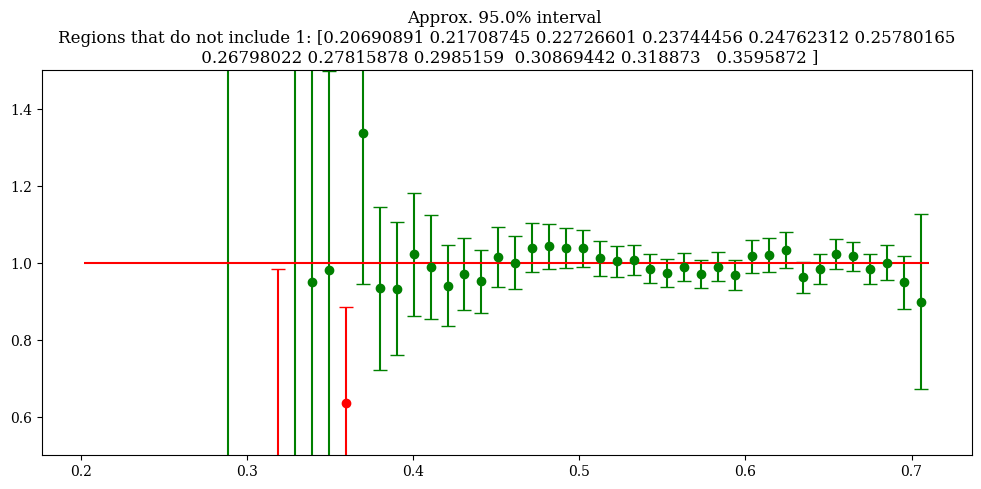

In [9]:
from plots import plot_prob_weighted_histogram1d, plot_prob_weighted_histogram2d
%matplotlib inline
labels_4b = clf.df_val[clf.yTrueLabel].values

for clf_type in ["sym_resnet"]:
    print(clf_type)
    probs_4b = eval(f"probs_4b_{clf_type}")
    probs_4b = probs_4b.cpu().numpy()
    plot_feature_arr = probs_4b
    plot_prob_weighted_histogram1d(probs_4b, plot_feature_arr, labels_4b,
                                    n_bins=50, 
                                    output_file="figures/weighted_hist_1d_{}_features_{}.pdf".format(
                                    clf_type, "probs_4b"), 
                                    sample_weights=weights,
                                    ylim=(0.5, 1.5))

Symmetrized ResNet


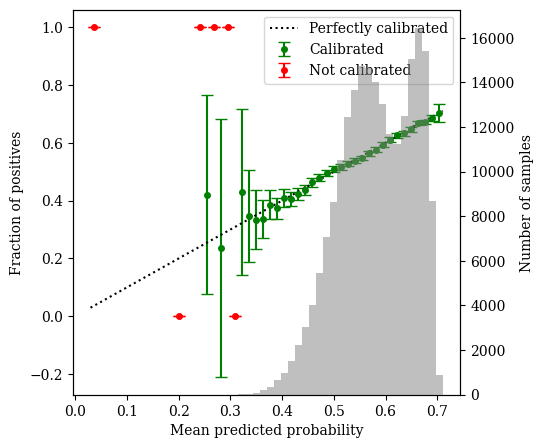

0.5799232


In [11]:
# Calibration plot
from plots import calibration_plot

%matplotlib inline

print("Symmetrized ResNet")
calibration_plot(probs_4b_sym_resnet, 
                 y_validation.detach().numpy(), 
                 bins=50,
                 sample_weights=clf.df_val[clf.weight].values
                 )
print(clf.df_val.loc[clf.df_val["fourTag"], clf.weight].sum() / clf.df_val[clf.weight].sum())

In [14]:

import matplotlib.pyplot as plt
import scipy.spatial.distance

%matplotlib inline

# normalize X_validation
features_tmp = ["canJet0_pt", "canJet1_pt", "canJet2_pt", "canJet3_pt",
                "canJet0_eta", "canJet1_eta", "canJet2_eta", "canJet3_eta",
                "canJet1_phi", "canJet2_phi", "canJet3_phi",
                "canJet0_m", "canJet1_m", "canJet2_m", "canJet3_m"]
normalized_X_val = clf.df_val[features_tmp].values
normalized_X_val = (normalized_X_val - np.mean(normalized_X_val, axis=0)) / np.std(normalized_X_val, axis=0)
is_4b = clf.df_val["fourTag"].values
weights = clf.df_val[clf.weight].values

n_pick = 20000
print("Total 4b ratio: ", np.sum(weights * is_4b) / np.sum(weights))

# shuffle and randomly pick n_pick samples
rand_idx = np.random.permutation(normalized_X_val.shape[0])[:n_pick]
normalized_X_val = normalized_X_val[rand_idx]
is_4b = is_4b[rand_idx]
weights = weights[rand_idx]
probs_4b_est = probs_4b_sym_resnet[rand_idx]

# calculate pairwise distance of normalized_X_val
dist = scipy.spatial.distance.cdist(normalized_X_val, normalized_X_val)

alpha_nearest = 0.01
n_nearest = int(n_pick * alpha_nearest)
ratio_4b = np.zeros(n_pick)
ratio_4b_est = np.zeros(n_pick)
for idx in range(normalized_X_val.shape[0]):
    nearest_idx = np.argsort(dist[idx])[:n_nearest]
    ratio_4b[idx] = np.sum(is_4b[nearest_idx] * weights[nearest_idx]) / np.sum(weights[nearest_idx])

Total 4b ratio:  0.5799232


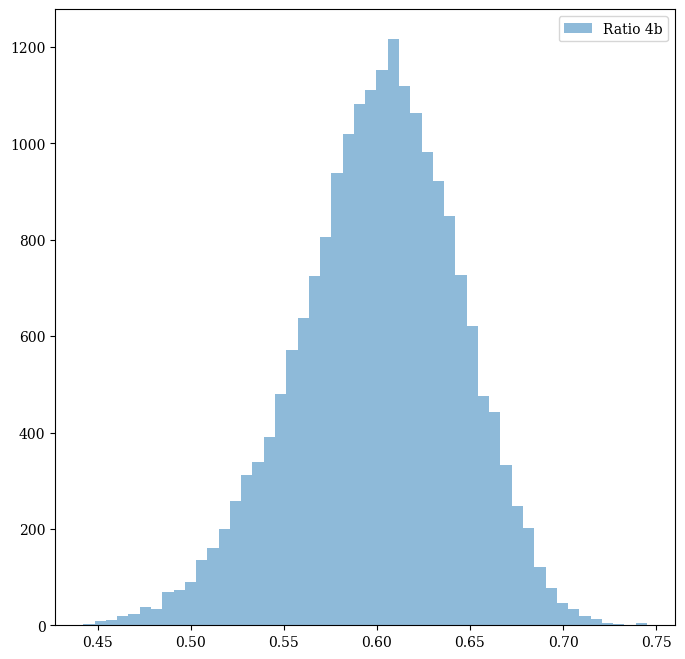

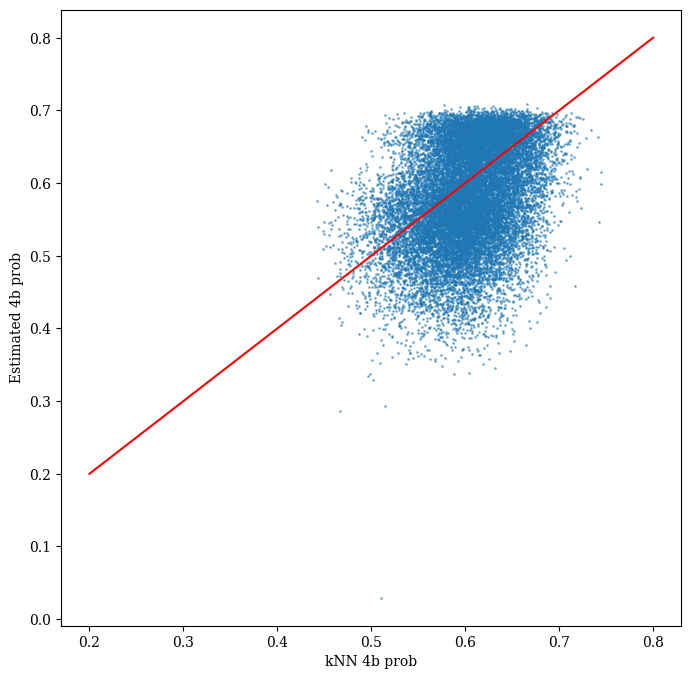

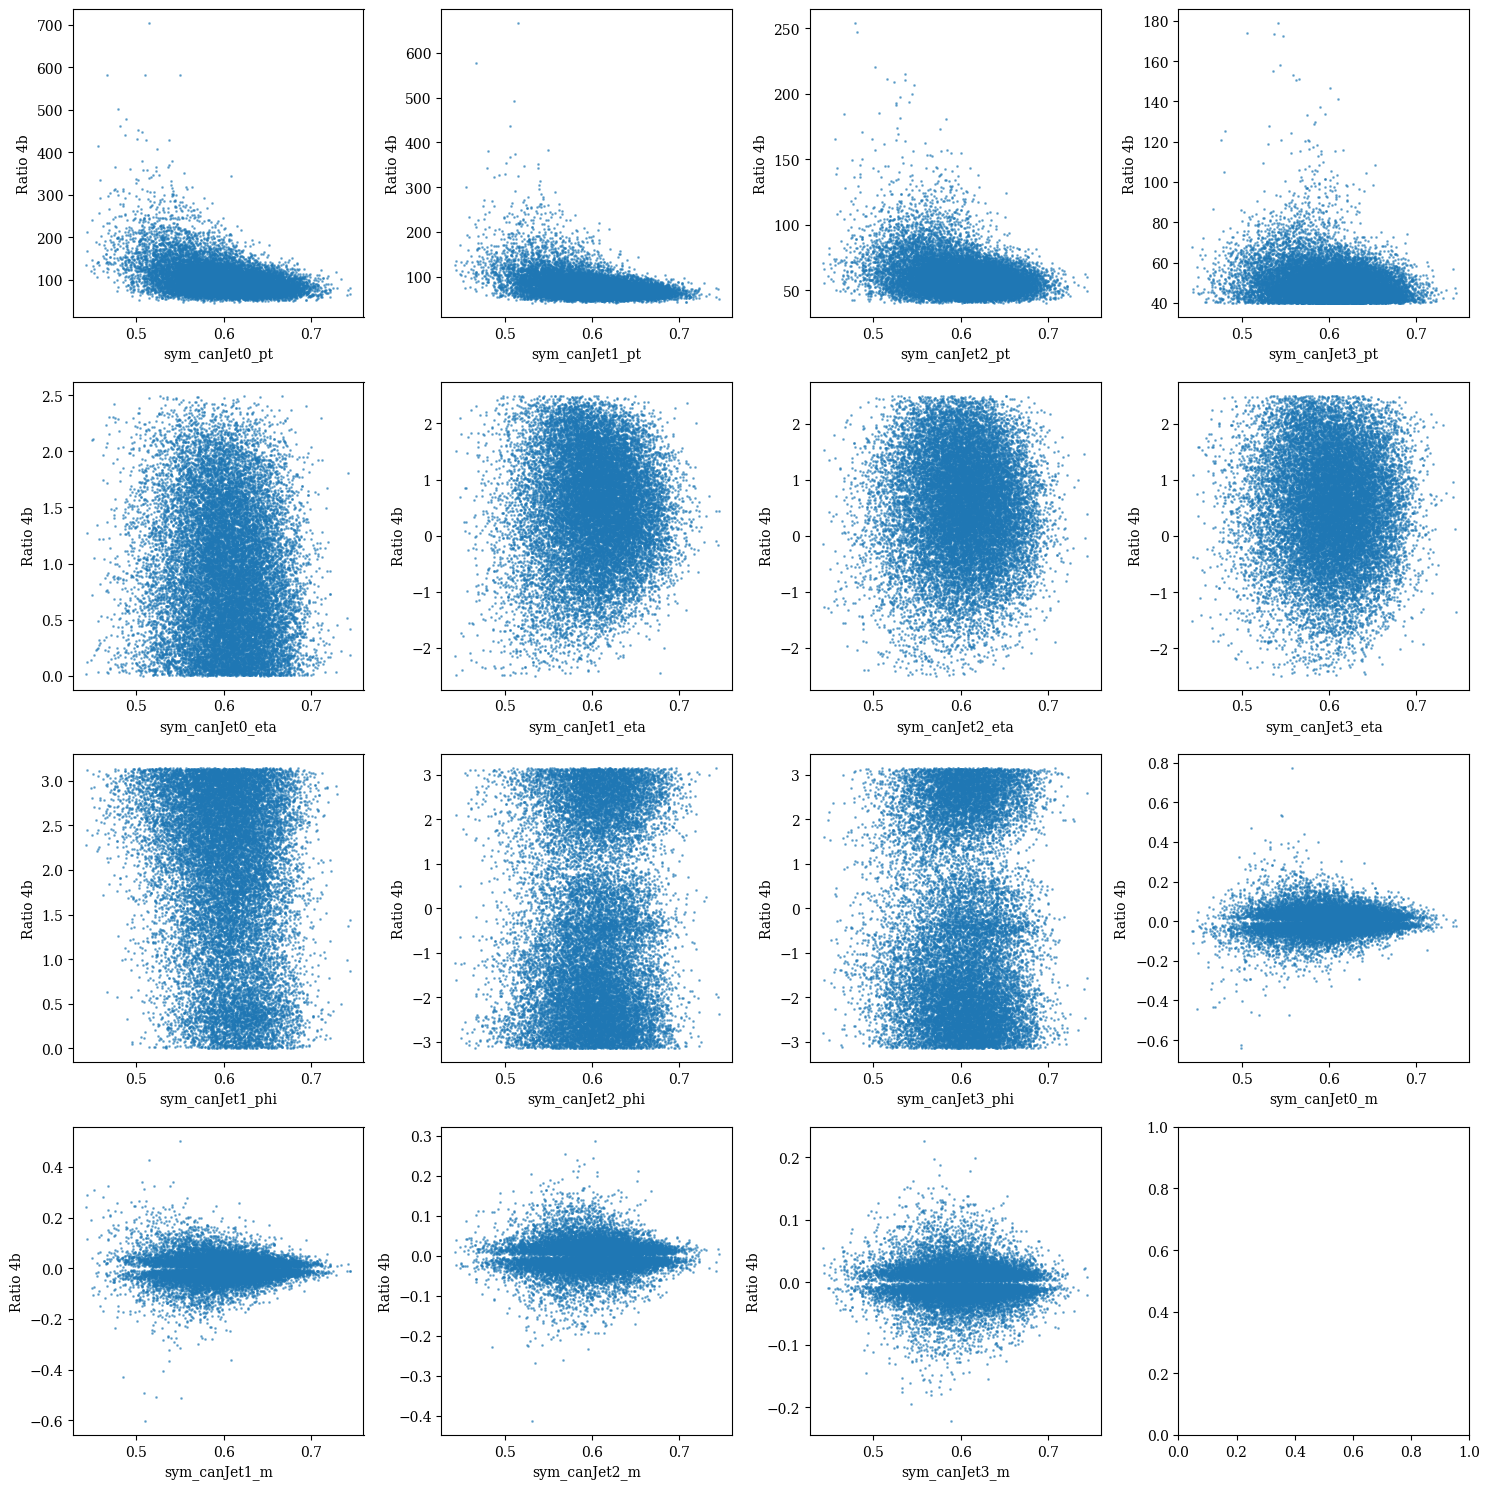

In [15]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.hist(ratio_4b, bins=50, alpha=0.5, label="Ratio 4b", weights=weights)
plt.legend()
plt.show()
plt.close()

plt.scatter(ratio_4b, probs_4b_est, alpha=0.5, s=1)
plt.xlabel("kNN 4b prob")
plt.ylabel("Estimated 4b prob")
plt.plot([0.2, 0.8], [0.2, 0.8], color="red")
plt.show()
plt.close()

fig, ax = plt.subplots(4, 4, figsize=(15, 15))
ax_cnt = 0
for i, feature in enumerate(features):
    current_ax = ax[i // 4, i % 4]
    current_ax.scatter(ratio_4b, clf.df_val[feature].values[rand_idx], alpha=0.5, s=1)
    current_ax.set_xlabel(feature)
    current_ax.set_ylabel("Ratio 4b")
plt.tight_layout()
plt.show()
plt.close()

KeyError: 0

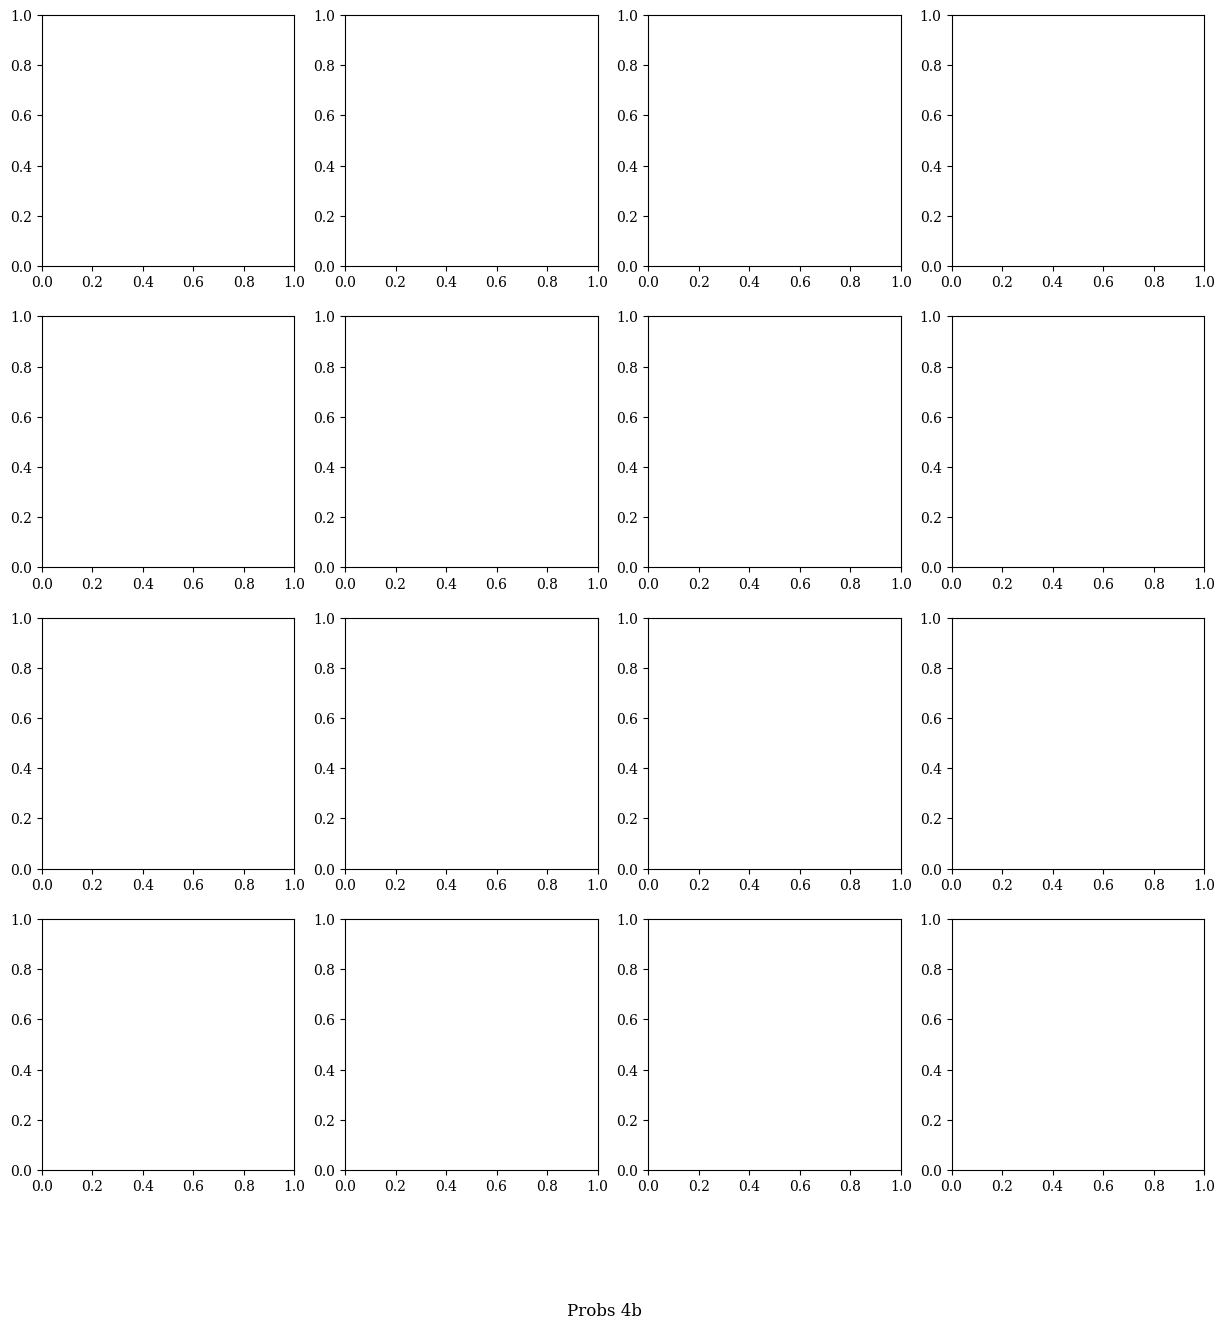

In [16]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
ax_cnt = 0
fig.supxlabel("Probs 4b")
bins = 100

prob_min, prob_max = min(probs_4b_sym_resnet), max(probs_4b_sym_resnet)
xs = np.linspace(prob_min, prob_max, bins + 1)
weights = clf.df_val[clf.weight].values
is_4b = clf.df_val["fourTag"]
    

for feature in features:
    feature_arr = clf.df_val[feature]
    
    current_ax = ax[ax_cnt // 4, ax_cnt % 4]
    
    # scatter 3b
    current_ax.scatter(probs_4b_sym_resnet[~is_4b], feature_arr[~is_4b], alpha=0.2, s=0.05, label="3b")
    # scatter 4b
    current_ax.scatter(probs_4b_sym_resnet[is_4b], feature_arr[is_4b], alpha=0.2, s=0.05, label="4b")
    current_ax.set_title(feature)

    avg_arr = np.zeros(bins)

    for i in range(bins):
        is_in_bin = (probs_4b_sym_resnet >= xs[i]) & (probs_4b_sym_resnet < xs[i + 1])
        if is_in_bin.sum() < 1e1:
            avg_arr[i] = np.nan
            continue
        avg_arr[i] = np.mean(feature_arr[is_in_bin] * weights[is_in_bin])

    current_ax.plot((xs[1:] + xs[:-1]) / 2, avg_arr, color="red")
    # larger marker for legend
    current_ax.legend(markerscale=10, loc="lower left")
    ax_cnt += 1

plt.show()
plt.close()

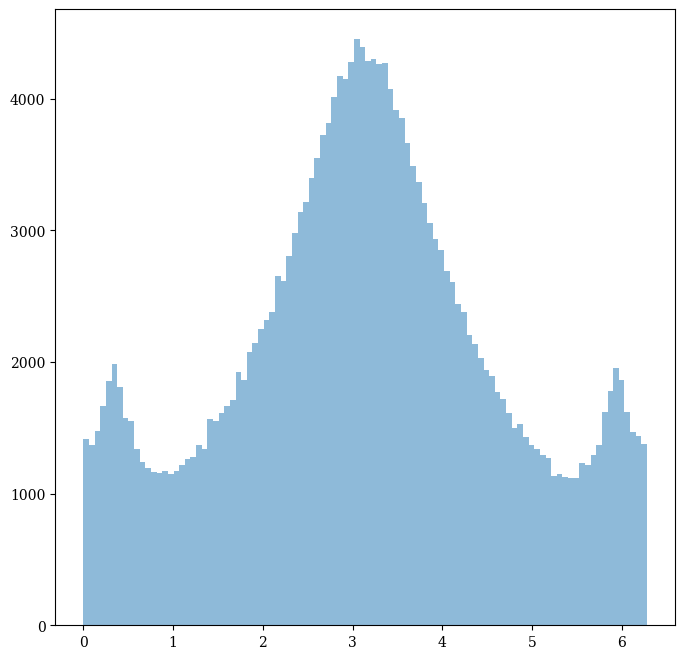

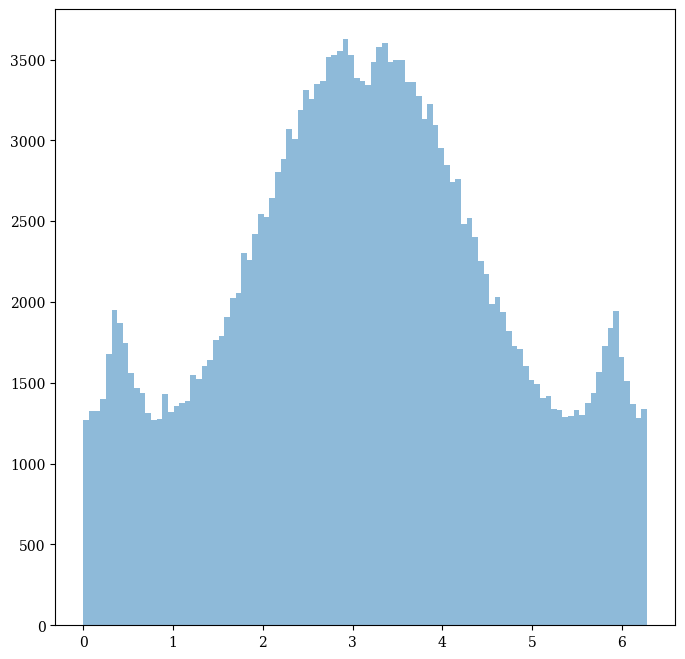

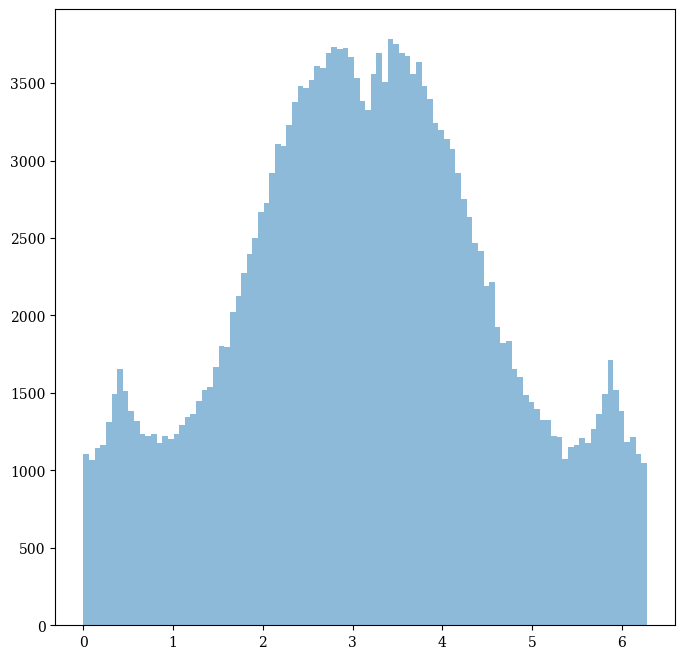

In [ ]:
plt.hist(clf.df_val.eval("canJet1_phi - canJet0_phi") % (2 * np.pi), bins=100, alpha=0.5, weights=clf.df_val[clf.weight].values)
plt.show()
plt.hist(clf.df_val.eval("canJet2_phi - canJet0_phi") % (2 * np.pi), bins=100, alpha=0.5, weights=clf.df_val[clf.weight].values)
plt.show()
plt.hist(clf.df_val.eval("canJet3_phi - canJet0_phi") % (2 * np.pi), bins=100, alpha=0.5, weights=clf.df_val[clf.weight].values)
plt.show()
plt.close()

/tmp/ipykernel_147619/4086042191.py:18: RuntimeWarning: invalid value encountered in scalar divide
  probs_4b_arr[i] = (is_4b[is_in_bin] * weights[is_in_bin]).sum() / weights[is_in_bin].sum()


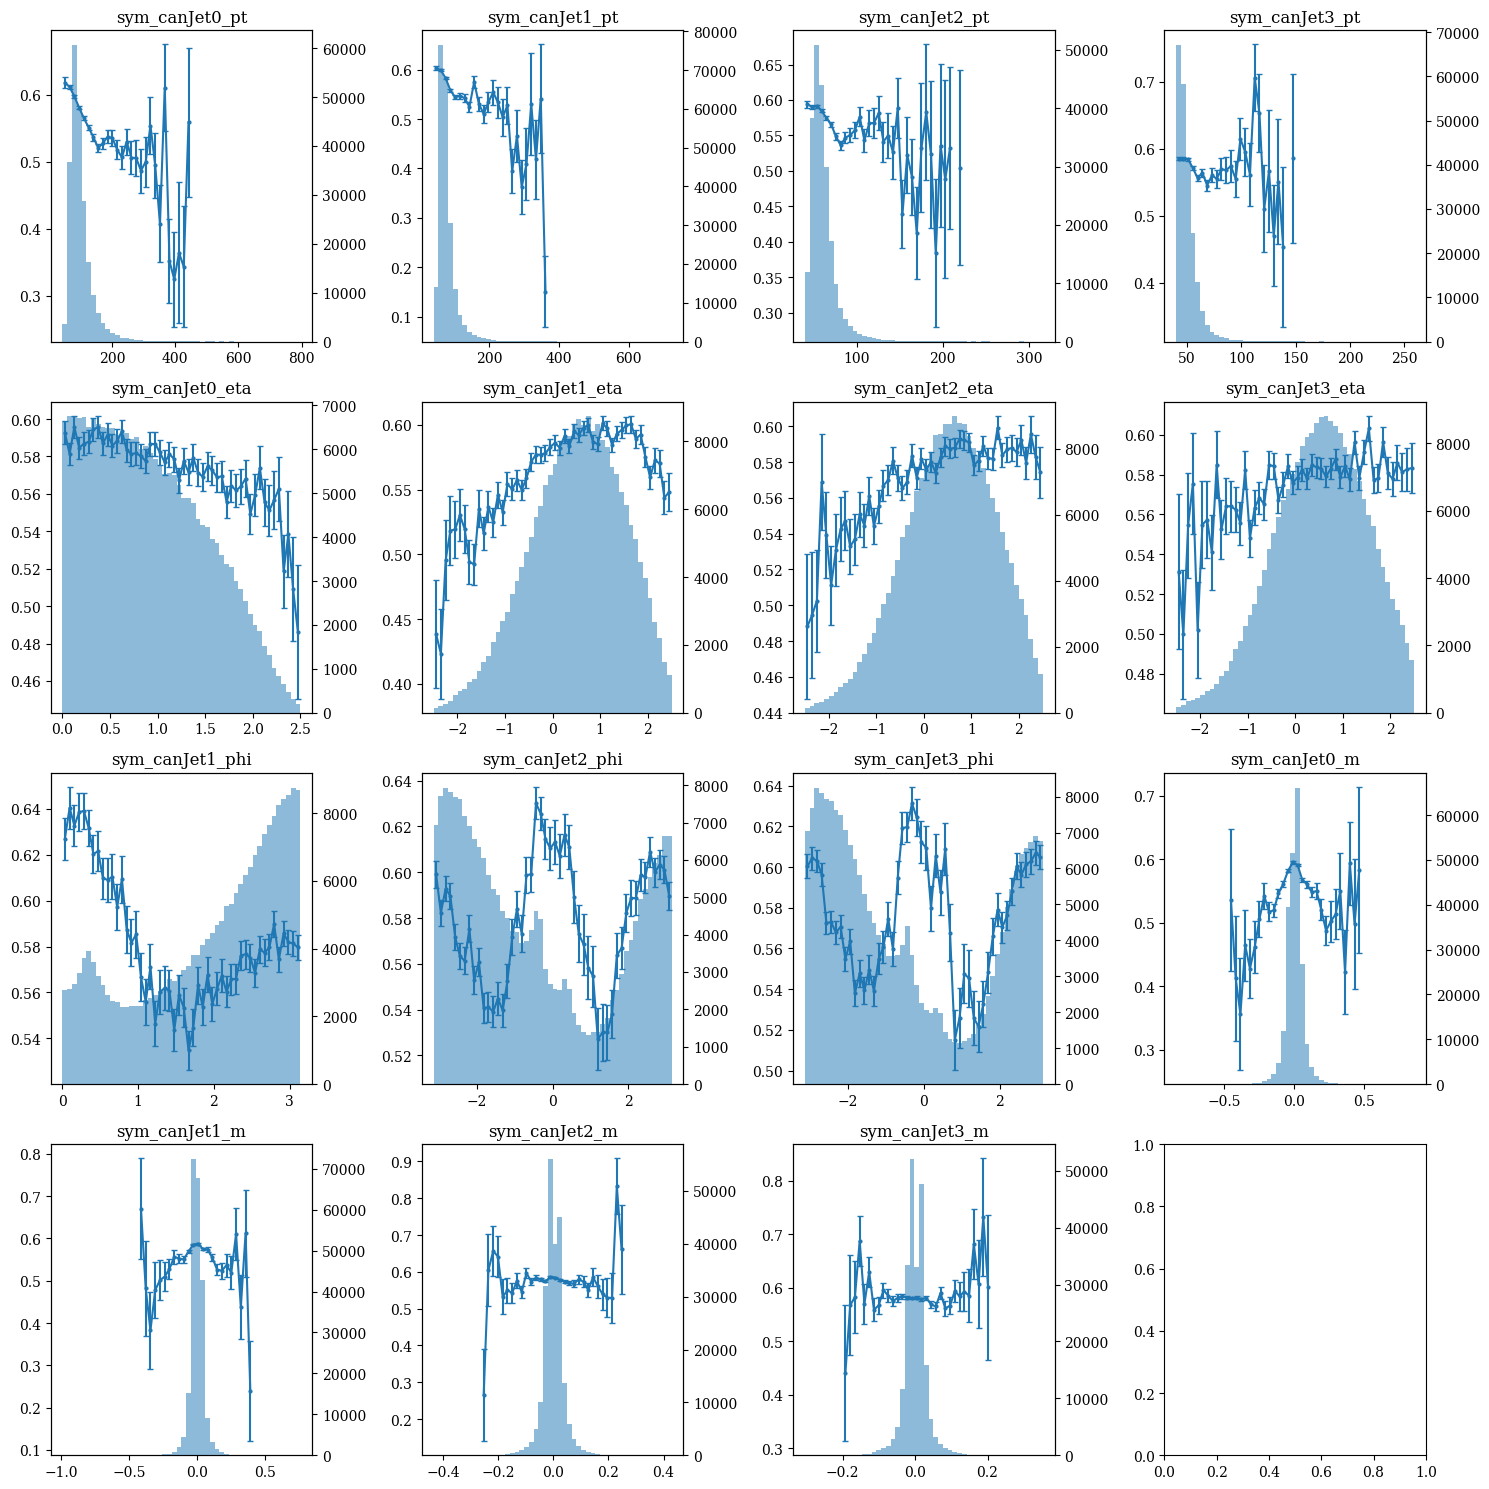

In [17]:
is_4b = clf.df_val["fourTag"].values
weights = clf.df_val[clf.weight].values
bins = 50

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
ax_cnt = 0
for feature in features:
    feature_arr = clf.df_val[feature].values

    feature_min, feature_max = min(feature_arr), max(feature_arr)
    xs = np.linspace(feature_min, feature_max, bins + 1)
    probs_4b_arr = np.zeros(bins)
    err_arr = np.zeros(bins)

    for i in range(bins):
        is_in_bin = (feature_arr >= xs[i]) & (feature_arr < xs[i + 1])

        probs_4b_arr[i] = (is_4b[is_in_bin] * weights[is_in_bin]).sum() / weights[is_in_bin].sum()
        err_arr[i] = np.sqrt((1 - probs_4b_arr[i]) * probs_4b_arr[i] / weights[is_in_bin].sum())

        if is_in_bin.sum() < 1e1:
            probs_4b_arr[i] = np.nan
            err_arr[i] = np.nan
            continue

    current_ax = ax[ax_cnt // 4, ax_cnt % 4]
    current_ax.errorbar((xs[1:] + xs[:-1]) / 2, probs_4b_arr, yerr=err_arr, fmt="o-", capsize=2, markersize=2)
    current_ax.set_title(feature)

    current_ax2 = current_ax.twinx()
    current_ax2.hist(feature_arr, bins=bins, alpha=0.5, weights=weights)

    ax_cnt += 1

plt.tight_layout()
plt.show()
plt.close()

## Gradients

In [19]:
# # Get gradients of output of clf.net for the validation set
# import torch
# from torch.autograd import grad

# J_val_, y_val_, w_val_ = clf.dfToTensors(
#     clf.df_val, y_true=clf.yTrueLabel)

# val_evalLoader = DataLoader(
#             dataset=TensorDataset(
#                 J_val_, y_val_, w_val_
#             ),
#             batch_size=2**10,
#             shuffle=False,
#             pin_memory=True,
#         )

# grads = torch.tensor([])
# logits = torch.tensor([])
# for J, y, w in val_evalLoader:
#     # to device
#     J = J.requires_grad_().to(clf.net.device)
#     y = y.to(clf.net.device)
#     w = w.to(clf.net.device)

#     c_score, quadjet_scores = clf.net(J)
#     logit = c_score[:, 1] - c_score[:, 0]

#     grad_ = grad(logit, J, 
#                  create_graph=True, 
#                  retain_graph=False,
#                  grad_outputs=torch.ones_like(logit))[0].detach().to("cpu")
    
#     grads = torch.cat((grads, grad_))
#     logit = logit.detach().to("cpu")
#     logits = torch.cat((logits, logit))


: 